In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import seaborn as sns
from pandas.api.types import CategoricalDtype
import itertools
from colour import Color
from datetime import date
import tifffile
import scipy  as spy
import skimage as ski

In [2]:
today = date.today()
print("Today's date:", today)
date_today = str(today)
date_today

Today's date: 2022-02-11


'2022-02-11'

In [3]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)
path

WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol')

In [6]:
folders = [x for x in path.iterdir() if x.is_dir()]
folders

[WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH2_DCXGFP0.7nM_typeWT_40P-yes'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH3_DCXGFP0.5nM_typeWT_40P-yes'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH4_DCXGFP0.6nM_typeWT_40P-yes')]

In [7]:
files = []
for j in folders:  
    files0 = [x for x in j.iterdir() if x.is_file()]
    files0 = [i for i in files0 if str(i).rfind('stack') != -1]
    files = files + files0
files

[WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/1-stack.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/2-stack.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/3-stack.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/4-stack.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/5-stack.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/6-stack.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH2

## Background Substraction ##

In [204]:
def background_substraction(image, median_size, gaussian_sigma):

    median = [np.empty((600,600))]
    gaussian = [np.empty((600,600))]
    
    for i in np.arange(len(raw)):
        
        median0 = spy.ndimage.median_filter(image[i], size=median_size)
        median = np.append(median, [median0],axis=0)

        gaussian0 = spy.ndimage.gaussian_filter(median0, sigma=gaussian_sigma)
        gaussian = np.append(gaussian, [gaussian0],axis=0)

    median = median[1:]
    gaussian = gaussian[1:]
    
    #sometimes a value in gaussian is bigger than in median, in which case the substraction acts module 16-bit and goes round to the highest value
    #this substitution makes sure the substraction goes to zero in those cases
    gaussian = np.where(gaussian > median, median, gaussian) 

    substract = median - gaussian
    
    substract = substract.astype(np.uint16)
    
    return substract

In [225]:
size=2
sigma=10

for i in files:
    
    raw = tifffile.imread(i)
    substract = background_substraction(raw, size, sigma)
    
    string_file =str(i)
    stackNo= string_file[string_file.rfind('-stack')-1:string_file.rfind('-stack')]
    path = i.parents[0]
    
    tifffile.imsave(path/(stackNo+'_Composite.tif'), substract)

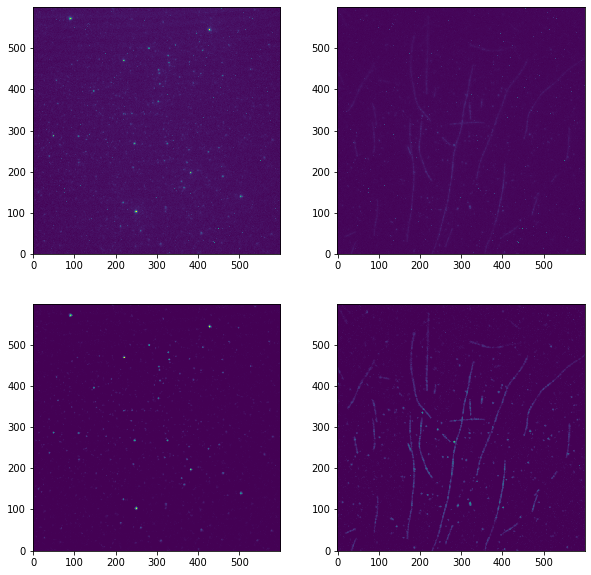

In [227]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(raw[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[0,1].imshow(raw[1], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,0].imshow(substract[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,1].imshow(substract[1], interpolation='none', origin=[0, 0], cmap='viridis')

## User must drift correct imagee ##

## Otsu Processing ##

In [15]:
processed_files = []
for j in folders:  
    files0 = [x for x in j.iterdir() if x.is_file()]
    files0 = [i for i in files0 if str(i).rfind('driftcorrected') != -1]
    processed_files = processed_files + files0
processed_files

[WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/1_Composite-driftcorrected.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/2_Composite-driftcorrected.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/3_Composite-driftcorrected.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/4_Composite-driftcorrected.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/5_Composite-driftcorrected.tif'),
 WindowsPath('C:/Users/Brouhard Lab/OneDrive/Documentos/2022_1winter/2022-01-26_DCX-HUGS-WT_freshtaxol/CH1_DCXGFP1.0nM_typeWT_40P-yes/6_Composite-driftcorrected

In [20]:
DCXconc = '[DCX] ' r'$(n M)$'
DCX = 'DCX'
Type = 'Type'
investigator = 'Sofia'

In [57]:
def acquire_metadata(processed_file_paths,investigator):

    ch = []
    imgNo = []
    conc_DCXGFP = []
    DCX_type = []
    dates = []
    
    n = len(processed_file_paths)

    for i in processed_file_paths:
        #get the file metadata
        CHstart = str(i).find('CH')
        CHend = str(i).find('_', CHstart)
        ch = ch + [str(i)[CHstart+2:CHend]]
        
        imgNostart = str(i).find('yes')
        imgNoend = str(i).find('_', imgNostart)
        imgNo = imgNo + [str(i)[imgNostart+4:imgNoend]]
        
        DCXGFPstart = str(i).rfind('DCXGFP')
        DCXGFPend = str(i).find('_', DCXGFPstart)
        conc_DCXGFP = conc_DCXGFP + [(str(i)[DCXGFPstart+6:DCXGFPend-2])]
        conc_DCXGFP =  [float(i) for i in conc_DCXGFP]
        
        dcxtypestart = str(i).find('type')
        dcxtypeend = str(i).find('_', dcxtypestart)
        DCX_type = DCX_type + [(str(i)[dcxtypestart+4:dcxtypeend])]
        
        dateloc = str(i).rfind("202")   
        dates = dates + [str(i)[dateloc : dateloc+10]]       
        
    pre_df = {'Date': dates, 'Investigator': np.full((n), investigator),
              'CH': ch , 'Image No': imgNo , DCXconc:conc_DCXGFP, Type:DCX_type}
    df = pd.DataFrame(pre_df) 
    
    return df
    

In [58]:
metadata = acquire_metadata(processed_files,investigator)
metadata

,Date,Investigator,CH,Image No,[DCX] $(n M)$,Type
0,2022-01-26,Sofia,1,1,1.0,WT
1,2022-01-26,Sofia,1,2,1.0,WT
2,2022-01-26,Sofia,1,3,1.0,WT
3,2022-01-26,Sofia,1,4,1.0,WT
4,2022-01-26,Sofia,1,5,1.0,WT
5,2022-01-26,Sofia,1,6,1.0,WT
6,2022-01-26,Sofia,2,1,0.7,WT
7,2022-01-26,Sofia,2,2,0.7,WT
8,2022-01-26,Sofia,2,3,0.7,WT
9,2022-01-26,Sofia,3,1,0.5,WT


In [51]:
def make_mt_mask(im_mts,mt_mask):
    
    #otsu filter
    otsu_marker = ski.filters.threshold_otsu(im_mts)
    im_mts_otsu = im_mts > otsu_marker

    #size filter
    label_objects, nb_labels = spy.ndimage.label(im_mts_otsu)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > mt_mask
    mask_sizes[0] = 0

    im_mts_cleaned = mask_sizes[label_objects]
    
    #convert to image type array
    im_mts_cleaned = im_mts_cleaned.astype(np.uint16)
    
    return im_mts_cleaned

In [53]:
def make_dcx_mask(im_mts_cleaned,im_dcx):
    
    im_dcx_masked = im_dcx * im_mts_cleaned
    otsu_marker_dcx_masked = ski.filters.threshold_otsu(im_dcx_masked)
    im_dcx_otsu_masked = im_dcx_masked > otsu_marker_dcx_masked
    im_dcx_otsu_masked = im_dcx_otsu_masked.astype(np.uint16)
    
    return im_dcx_otsu_masked

In [72]:
def colocalization_processing(processed_file_paths):
    
    mt_mask = 20
    
    coloc = []

    for i in processed_file_paths:
    
        #Process Otsu masks
        im_dcx,im_mts = tifffile.imread(i)
        
        im_mts_cleaned = make_mt_mask(im_mts,mt_mask)
        
        im_dcx_otsu_masked = make_dcx_mask(im_mts_cleaned,im_dcx)
        
        #Calculate colocalization
        coloc0 = np.sum(im_dcx_otsu_masked)/np.sum(im_mts_cleaned)
        coloc = coloc + [coloc0]
        
        #Save processed images
        resultdirectory = str(composite.parents[0])+'//results'
        resultdir = Path(resultdirectory)
        resultdir.mkdir(exist_ok=True)
        
        imgNostart = str(i).find('yes')
        imgNoend = str(i).find('_', imgNostart)
        imgNo = str(i)[imgNostart+4:imgNoend]
        
        im = np.append([im_dcx], [im_mts],axis=0)
        im_cleaned = np.append([im_dcx_otsu_masked], [im_mts_cleaned],axis=0)
        tifffile.imsave(resultdir/(imgNo+'_processed.tif'), im_cleaned)
        
    return coloc, im, im_cleaned
    

In [73]:
coloc,im, im_cleaned = colocalization_processing(processed_files)

In [74]:
Coloc = 'Colocalization'
metadata[Coloc] = coloc
results = metadata
results

,Date,Investigator,CH,Image No,[DCX] $(n M)$,Type,Colocalization
0,2022-01-26,Sofia,1,1,1.0,WT,0.228372
1,2022-01-26,Sofia,1,2,1.0,WT,0.150738
2,2022-01-26,Sofia,1,3,1.0,WT,0.120429
3,2022-01-26,Sofia,1,4,1.0,WT,0.135520
4,2022-01-26,Sofia,1,5,1.0,WT,0.148815
5,2022-01-26,Sofia,1,6,1.0,WT,0.153853
6,2022-01-26,Sofia,2,1,0.7,WT,0.187391
7,2022-01-26,Sofia,2,2,0.7,WT,0.223194
8,2022-01-26,Sofia,2,3,0.7,WT,0.090665
9,2022-01-26,Sofia,3,1,0.5,WT,0.005888


In [69]:
newdirectory = str(path.parents[0])+'//Colocalization_Data_Sheets'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [71]:
results.to_csv(path/(investigator+'_'+date_today +'.csv'), encoding='utf-8', index=False)
results.to_csv(newmydir/(investigator+'_'+date_today+'.csv'), encoding='utf-8', index=False)

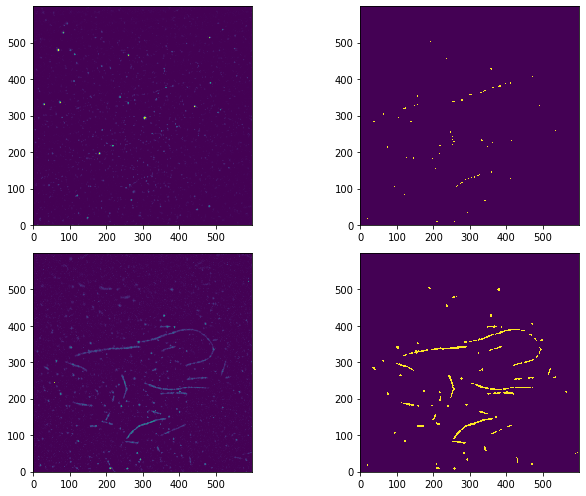

In [76]:
fig, ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].imshow(im[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[0,1].imshow(im_cleaned[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,0].imshow(im[1], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,1].imshow(im_cleaned[1], interpolation='none', origin=[0, 0], cmap='viridis')

plt.tight_layout()

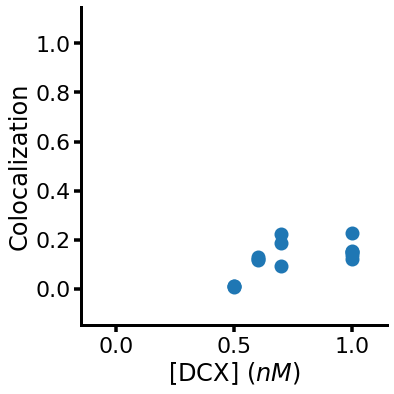

In [84]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(results[DCXconc], results[Coloc])
sns.despine()
sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)
ax.set_ylim(-0.15,1.15)
ax.set_xlim(-0.15,1.15)
ax.set_xlabel( DCXconc)
ax.set_ylabel(Coloc)

plt.tight_layout()

In [68]:
coeff_masked, pval = spy.stats.pearsonr(im_mts_cleaned.flatten(), im_dcx_masked.flatten())
coeff_otsu, pval = spy.stats.pearsonr(im_mts_cleaned.flatten(), im_dcx_otsu.flatten())
coeff_otsu_masked, pval = spy.stats.pearsonr(im_mts_cleaned.flatten(), im_dcx_otsu_masked.flatten())
coeff_masked, coeff_otsu, coeff_otsu_masked

(0.48384799516348004, 0.3387599598394834, 0.37688674000392214)